<a href="https://colab.research.google.com/github/andyrids/hybrid-association/blob/main/Hybrid_Spatio_temporal_Association_Within_Standardised_%26_Non_standardised_Space.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.ticker import FixedLocator, AutoLocator, AutoMinorLocator
from mpl_toolkits.mplot3d import Axes3D

## Confidence Calculations

The confidence metrics in this spatio-temporal clustering approach are designed to quantify the certainty that an event and track are meaningfully associated.

### Spatial Confidence

This confidence value is calculated using the following formula:

$spatial\_confidence = 1.0 - \left(\frac{min\_distance}{threshold}\right)$

This represents a linear normalization of Euclidean distance in ECEF coordinates.

*   $min\_distance$: Minimum distance (meters) between an event and track coordinates.
*   $threshold$: Maximum allowable distance (meters) for association
*   $ratio$: $\frac{min\_distance}{threshold}\in[0,1]$
*   $confidence\_inversion$: 1.0 - $ratio$

This creates a **linear decay function**, which is a type of function that decreases at a constant rate over time or distance. This function is represented by a straight line with a negative slope when graphed. As $min\_distance$ increases, $spatial\_confidence$ decreases at a constant rate.

If $distance\_threshold = 1000$:

*   Perfect spatial overlap (0m): 1.0 confidence
*   Maximum distance (1000m): 0.0 confidence
*   Half threshold distance (500m) → 0.5 confidence

This linear relationship suggests that halving the distance dioiubles the confidence and there are no confidence discontinuities.

In [ ]:
y=2x+1

f(x)=2x+1

f(x) = 1.0 - (x / threshold)

In [6]:
1 - (np.linspace(100, 1000, 10) / 1000)

array([0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0. ])

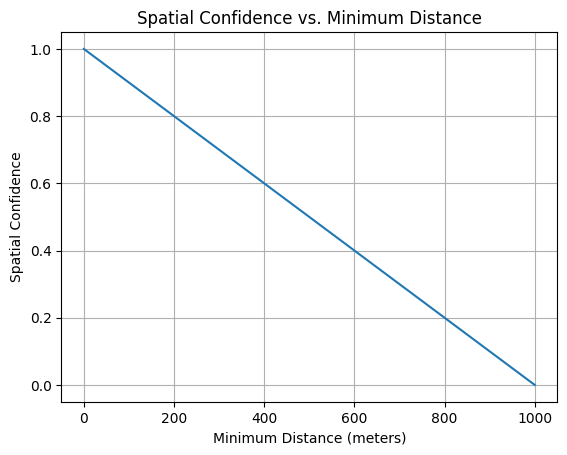

In [10]:
# prompt: fix the graph below so the line plots

import matplotlib.pyplot as plt
import numpy as np

threshold = 1000
x = np.linspace(0, threshold, 100)
y = 1.0 - (x / threshold)

plt.plot(x, y)
plt.xlabel("Minimum Distance (meters)")
plt.ylabel("Spatial Confidence")
plt.title("Spatial Confidence vs. Minimum Distance")
plt.grid(True)
plt.show()


In [23]:
y.size

100

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

In [26]:
np.arange(-1, y.size + 1 / 10)

array([ -1.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,
        10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,
        21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,
        32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,
        43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,
        54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,
        65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,
        76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,
        87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,
        98.,  99., 100.])

In [ ]:
# prompt: increase the width of legend

import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import FixedLocator, AutoLocator, AutoMinorLocator
from mpl_toolkits.mplot3d import Axes3D


# ## Confidence Calculations
#
# The confidence metrics in this spatio-temporal clustering approach are designed to quantify the certainty that an event and track are meaningfully associated.
#
# ### Spatial Confidence
#
# This confidence value is calculated using the following formula:
#
# $spatial\_confidence = 1.0 - \left(\frac{min\_distance}{threshold}\right)$
#
# This represents a linear normalization of Euclidean distance in ECEF coordinates.
#
# *   $min\_distance$: Minimum distance (meters) between an event and track coordinates.
# *   $threshold$: Maximum allowable distance (meters) for association
# *   $ratio$: $\frac{min\_distance}{threshold}\in[0,1]$
# *   $confidence\_inversion$: 1.0 - $ratio$
#
# This creates a **linear decay function**, which is a type of function that decreases at a constant rate over time or distance. This function is represented by a straight line with a negative slope when graphed. As $min\_distance$ increases, $spatial\_confidence$ decreases at a constant rate.
#
# If $distance\_threshold = 1000$:
#
# *   Perfect spatial overlap (0m): 1.0 confidence
# *   Maximum distance (1000m): 0.0 confidence
# *   Half threshold distance (500m) → 0.5 confidence
#
# This linear relationship suggests that halving the distance dioiubles the confidence and there are no confidence discontinuities.
y=2x+1

f(x)=2x+1

f(x) = 1.0 - (x / threshold)
1 - (np.linspace(100, 1000, 10) / 1000)


threshold = 1000
x = np.linspace(0, threshold, 100)
y = 1.0 - (x / threshold)

plt.plot(x, y)
plt.xlabel("Minimum Distance (meters)")
plt.ylabel("Spatial Confidence")
plt.title("Spatial Confidence vs. Minimum Distance")
plt.grid(True)

# Increase the width of the legend
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['legend.handlelength'] = 2


plt.show()

y.size
np.arange(-1, y.size + 1 / 10)


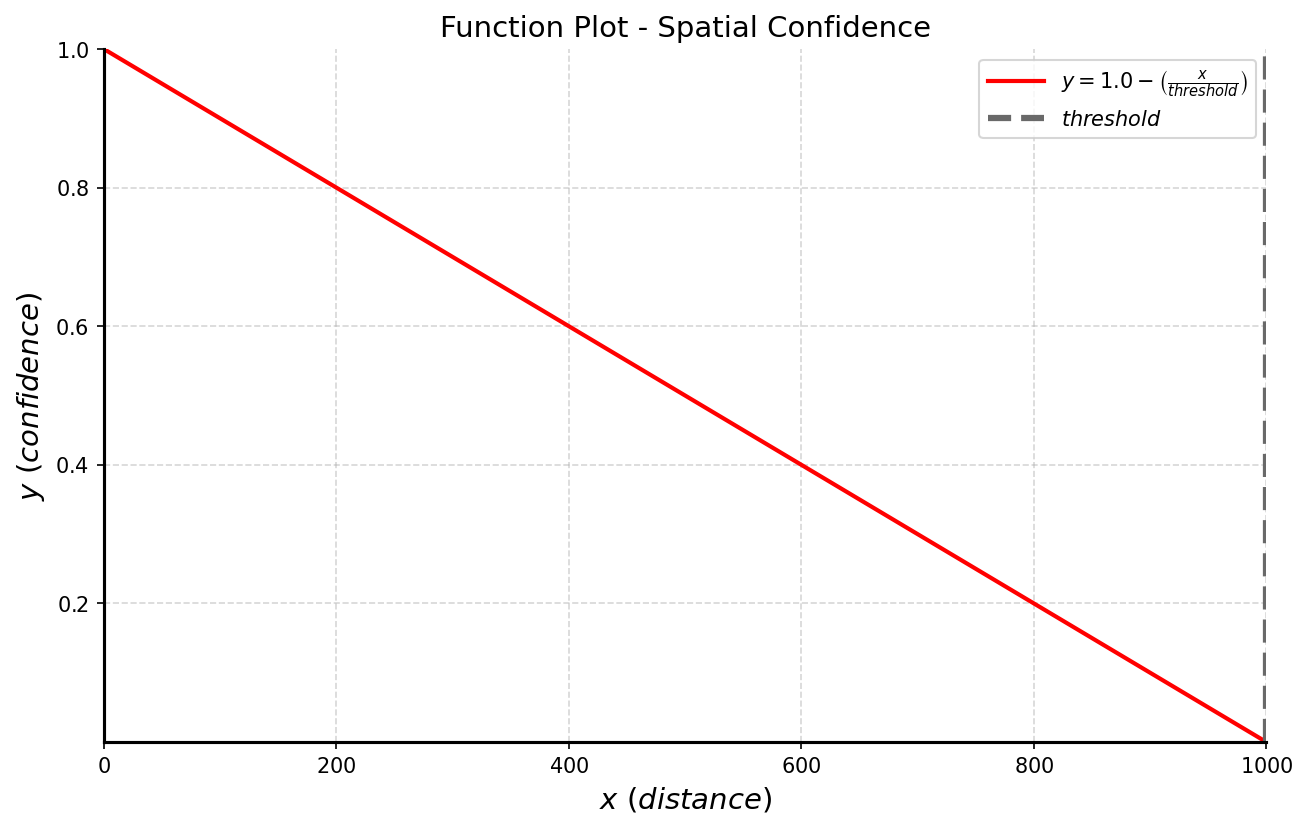

In [95]:
# f(x) = 1.0 - (x / THRESHOLD)
THRESHOLD = 1000
x = np.linspace(0, THRESHOLD, 100)
y = 1.0 - (x / THRESHOLD)
# y = 2 * x + 1

fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
ax.plot(x, y, color="r", label=r'$y = 1.0 - \left(\frac{x}{threshold}\right)$', linewidth=2)

ax.axvline(THRESHOLD, ls='--', color='dimgrey', linewidth=3, label=r'$threshold$')

ax.set_title("Function Plot - Spatial Confidence", fontsize=14)

ax.set(
    xlim=(-0, 1000),
    ylim=(-0, 1),
    yticks=list(filter(bool, np.linspace(0, 1, 6)))
)

ax.xaxis.set_major_locator(AutoLocator())

ax.ticklabel_format(useMathText=True)
ax.grid(alpha=.5, linestyle="--")

ax.set_xlabel(r'$x \ (distance)$', fontsize=14, position="right")
ax.set_ylabel(r'$y \ (confidence)$', fontsize=14, position="top")

ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")

ax.spines[["top", "right"]].set_visible(False)
ax.spines[["bottom", "left"]].set_position("zero")
ax.spines["bottom"].set(linewidth=1.5)
ax.spines["left"].set(linewidth=1.5)

xgrid_lines = ax.get_xgridlines()
ygrid_lines = ax.get_ygridlines()
xgrid_lines[0].set_visible(False)
ygrid_lines[-1].set_visible(False)

ax.legend(handlelength=2.7, fontsize='medium', fancybox=True)
plt.show()

In [90]:
plt.close("all")

In [21]:
x.shape

(100,)

In [22]:
y.shape

(100,)

In [ ]:
mpl.